Synced Dataset Size: 16153 rows
Preprocessing complete! Files saved to data/ folder.


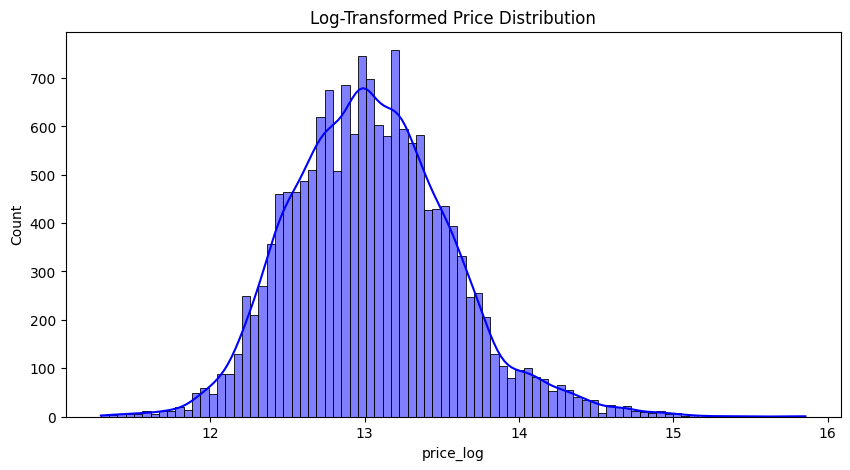

Scaler saved for the training notebook!


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. LOAD AND SYNC
# Load the raw Excel data
df = pd.read_excel("train(1).xlsx")

# Identify which images were successfully downloaded
image_folder = "house_images"
downloaded_ids = [int(f.split('.')[0]) for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Keep only rows that have a corresponding image
df_clean = df[df['id'].isin(downloaded_ids)].copy()
print(f"Synced Dataset Size: {len(df_clean)} rows")


df_clean = df_clean[df_clean['bedrooms'] < 30]
df_clean = df_clean[(df_clean['bedrooms'] > 0) & (df_clean['bathrooms'] > 0)]
df_clean = df_clean.drop_duplicates(subset='id')

# 3. FEATURE ENGINEERING (Tabular)
# Target Transformation: Use Log Price to normalize the distribution
df_clean['price_log'] = np.log1p(df_clean['price'])
# Transform years into 'Age' for better linear correlation
df_clean['house_age'] = 2025 - df_clean['yr_built']
df_clean['is_renovated'] = (df_clean['yr_renovated'] > 0).astype(int)
# Log-transform Lot size to handle high variance in land area
df_clean['sqft_lot_log'] = np.log1p(df_clean['sqft_lot'])

features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot_log', 'floors', 'waterfront', 
            'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
            'lat', 'long', 'house_age', 'is_renovated']

# Handle missing columns (if any)
available_features = [f for f in features if f in df_clean.columns]
X_tabular = df_clean[available_features]
y = df_clean['price_log']

# 4. SCALING
# Scale features so sqft (thousands) and bedrooms (units) are comparable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tabular)

# Convert back to a DataFrame for easy saving
X_scaled_df = pd.DataFrame(X_scaled, columns=available_features)
X_scaled_df['id'] = df_clean['id'].values
X_scaled_df['price_log'] = y.values

# 5. SPLIT DATA
# Split into Train and Test (80/20)
train_df, test_df = train_test_split(X_scaled_df, test_size=0.2, random_state=42)

# 6. SAVE PROCESSED DATA
train_df.to_csv("data/processed_train.csv", index=False)
test_df.to_csv("data/processed_test.csv", index=False)
print("Preprocessing complete! Files saved to data/ folder.")

# 7. QUICK VISUAL CHECK
plt.figure(figsize=(10, 5))
sns.histplot(df_clean['price_log'], kde=True, color='blue')
plt.title("Log-Transformed Price Distribution")
plt.show()

import joblib
joblib.dump(scaler, 'data/scaler.pkl')
print("Scaler saved for the training notebook!")